In [374]:
import numpy as np
import cv2
import random
import pprint
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from skimage import feature
from skimage.draw import circle_perimeter,circle
from skimage.io import imread, imsave


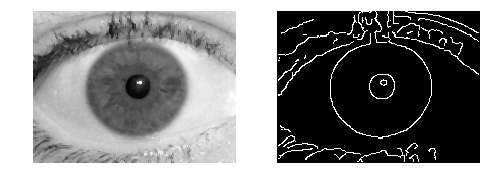

In [270]:
img = imread('D:/Ubiris_GRAY/Sessao_1/1/Img_1_1_1.jpg',as_gray=True)
#img = imread('D:/MMU/iris8.bmp',as_gray=True)
img = cv2.medianBlur(img,3)
borda = feature.canny(img,2)
borda = borda.astype(np.uint8)
bordacop = borda.copy()
bordacop[borda>0]=255
fig,axi = plt.subplots(ncols=2,nrows=1,figsize=(8,3))
ax1,ax2 = np.extract(axi.ravel(),axi)

ax1.axis('off')
ax1.imshow(img,cmap='gray')

ax2.axis('off')
ax2.imshow(borda,cmap='gray')


# Estrutura do algoritmo

- Cromossomo tem 17 bits variando entre 0 ou 1

> Ex \[ 1 , 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0 \]

### Os 6 primeiros bits são para centro x

### Os proximos 6 bits para os centro y

### Os ultimos 5 para representar o raio


* $x_c$ está na faixa de pixels $69$ a $132$
    onde 69 representa o inicio da contagem 0 ee 132 o fim 64
* $y_c$ está na faixa de pixel $33$ a $107$

* $r$ tem valores entre $5$ e $36 $para pupila

* $r$ ja para iris varia de $40$ a $71$


> 50 individuo

> Taxa cruzamento $90 \%$

> Taxa mutação $20\%$

In [398]:
populacao = np.random.randint(0,2,size=(50,17))

In [325]:
def bin2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y

In [401]:
for ite in range(60):
    aptidao =[]
    for i in populacao:
        
        x = bin2int(i[:6])+69
        y = bin2int(i[6:12])+44
        r = bin2int(i[12:17])+5
        rr,cc = circle_perimeter(x,y,r,shape=borda.shape)
        
        circAux= np.zeros(borda.shape)
        circAux[rr,cc] = 1
        
        aptidao.append((score(circAux,borda),i))

       # print("Pos {};Socore{};Diagonal{}".format(i,score(circAux,borda),diagonal))
    
    aptidao = sorted(aptidao,key=lambda x:x[0])
    populacao[0] = aptidao[-1][1]
    populacao[1] = aptidao[-2][1]
    novaPoulacao(populacao[0],populacao[1],populacao,0.9,0.2)
    buscaLocal(populacao)

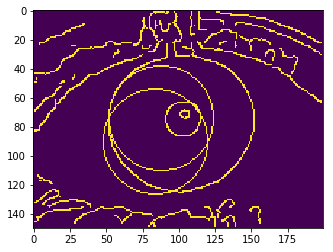

In [402]:
copia = borda.copy()

for i in aptidao[-5:-1]:
    x = bin2int(i[1][:6])+69
    y = bin2int(i[1][6:12])+44
    r = bin2int(i[1][12:17])+5
    rr,cc = circle_perimeter(x,y,r,shape=borda.shape)
    copia[rr,cc]=1
plt.imshow(copia)

In [273]:
def score(circulo,borda):
    count = 0
    for i in match(circulo,borda):
        count+=1
    return count

In [274]:
def match(circulo,borda):
    for i in range(borda.shape[0]):
        for j in range(borda.shape[1]):
            if borda[i,j] >0 and borda[i,j] == circulo[i,j]:
                yield (i,j)

In [275]:
def acharDig(circulo,borda,cx,cy):
    q1 =0
    q2 =0
    q3=0
    q4=0
    
    for i in match(circulo,borda):
        if i[0]>=cx and i[1]>=cy:
            q1+=1
        elif i[0]>=cx and i[1]<=cy:
            q4+=1
        elif i[0]<=cx and i[1]>=cy:
            q2+=1
        else: q3+=1
    pos = [q1,q2,q3,q4]
    
    maior = pos.index(max(pos))
    
    if maior is 0: return 'q1'
    elif maior is 1: return 'q2'
    elif maior is 2: return 'q3'
    elif maior is 3: return 'q4'

In [276]:
def novaPoulacao(gene1,gene2,populacaoAntiga,probCruzamento,probMutacao):
    for i in range(2,10,2):
        populacaoAntiga[i] = gene1
        populacaoAntiga[i+1] = gene2
        
        if np.random.random_sample() < probCruzamento:
            populacaoAntiga[i],populacaoAntiga[i+1] = cruzar(gene1,gene2)
        if np.random.random_sample() < probMutacao:
            mutar(populacaoAntiga[i])
            mutar(populacaoAntiga[i+1])

In [277]:
def cruzar(gen1,gen2):
    ptCorte = np.random.randint(1,17)
    novoGen = np.array(gen1[:ptCorte])
    novoGen = np.append(novoGen, gen2[ptCorte:])
    novoGen2 =  np.array(gen2[:ptCorte])
    novoGen2 =  np.append(novoGen2,gen1[ptCorte:])
    return novoGen,novoGen2

In [278]:
def mutar(gene):

    qtdGenes = random.randint(1,17)
    posMutacao = random.sample(range(17),qtdGenes)   
    gene[posMutacao]=np.bitwise_not(gene[posMutacao].astype(np.bool)).astype(np.uint8)


In [389]:

def buscaLocal(population,pupila=True):
    for i in range(len(population)):

        x = bin2int(population[i][:6])+69
        y = bin2int(population[i][6:12])+44
        r = bin2int(population[i][12:17])+5
        rr,cc = circle_perimeter(x,y,r,shape=borda.shape)
        circAux= np.zeros(borda.shape)
        circAux[rr,cc] = 1
        diagonal=acharDig(circAux,borda,x,y)

        x1 = x
        x2 = x
        y1 = y
        y2 = y
        r1 = r
        r2 = r
        if  diagonal == 'q2' or  diagonal == 'q4':
            variacentro = 0
            variaraio = 0
            while variacentro < 15:
                x1 += 1
                y1 += 1

                x2 -= 1
                y2 -= 1

                
                if x1 >132 or x2 < 69:
                    break
                if y1 > 107 or y2 < 44:
                    break
                
                while variaraio < 15:
                    r1 += 1
                    r2 -=1
                    
                    #verifica o raio se e para puppila ou iris
                    if pupila:
                        if r1 > 36 or r2 < 5:
                            break
                    else:
                        if r1 > 71 or r2 < 40:
                            break
                    circLocal = criarCirculo(population[i])
                    scoreLocal = score(circLocal,borda)
                    
                    circSoma = criarCirculoCentro(x1,y1,r1)
                    scoreSoma = score(circulo=circSoma,borda=borda)
                    
                    circSub = criarCirculoCentro(x2,y2,r2)
                    scoreSub = score(circulo=circSub,borda=borda)

                    if scoreSoma > scoreLocal and scoreSoma > scoreSub:
                        population[i] = dec2bin(x1-69) + dec2bin(y1-44) + dec2bin(r1-5,5)

                    elif scoreSub > scoreLocal and scoreSub >scoreSoma:
                        population[i] = dec2bin(x2-69) + dec2bin(y2-44) + dec2bin(r2-5,5)
                     
                    
                    variaraio +=1
                variacentro +=1
                


In [280]:
def dec2bin(n,qtdBit=6):
    b = ''
    while n != 0:
        b = b + str(n % 2)
        n = int(n / 2)
    rest = 0
    if len(b) < qtdBit:
        rest = qtdBit -len(b)
    zeros = list('0'*rest)
    b=list(b)
    b.extend(zeros)
    return list(map(int,b))

In [281]:
def criarCirculo(individuo):
    x = bin2int(individuo[:6])+66
    y = bin2int(individuo[6:12])+44
    r = bin2int(individuo[12:17])+5
    rr,cc = circle_perimeter(x,y,r,shape=borda.shape)

    circulo= np.zeros(borda.shape)
    circulo[rr,cc] = 1
    
    return circulo

In [282]:
def criarCirculoCentro(x,y,r):
    rr,cc = circle_perimeter(x,y,r,shape=borda.shape)
    circulo= np.zeros(borda.shape)
    circulo[rr,cc] = 1
    
    return circulo